# GENIA Filtered Type Analysis
The GENIA dataset used in many NER papers, including the DyGIE++ paper, is reduced to only 5 of the original 47 entity mention types: DNA, RNA, Protein, Cell Line, and Cell Type. This explains much of the unexpected poor performance of the GENIA model; the model performs exceptionally well on the DNA, RNA and Protein types, and our PICKLE dataset doesn't have many Cell annotations at all. Here, we look at the performacne of the GENIA model if we filter the PICKLE test set down to just those types represented in the GENIA model before evaluation. We perform this filtering using the script `filter_pickle_to_GENIA.py` in the `annotation/abstract_scripts` directory.

In [64]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from ast import literal_eval
import numpy as np

## Reading in data
### Performance data
First, let's read in the original performance data:

In [65]:
orig_perf_seedev = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/17Jul2023_seedev_on_pickle_performance_no_labels.csv')
orig_perf_all = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/15Jul2023_all_on_pickle_no_seedev_performance.csv')
orig_perf_all = pd.concat([orig_perf_seedev, orig_perf_all])
orig_perf_all['model'] = orig_perf_all['pred_file'].str.split('_').str[-2]
orig_perf_all = orig_perf_all.drop(index=1).reset_index(drop=True)
orig_perf_all

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.373344,0.314438,0.340887,0.167352,0.066984,0.094928,"(0.31789976918733104, 0.4304071630210769)","(0.26929228179228176, 0.35934436835687483)","(0.29586052643654476, 0.3803187764879307)","(0.04750056420672534, 0.349972186904005)","(0.017564797672573393, 0.14164540816326524)","(0.0264594334393325, 0.19697090527267153)",seedev
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.883557,0.891106,0.887275,0.608037,0.348510,0.442015,"(0.857079027355623, 0.9084136564951275)","(0.8753625636815292, 0.9081251757571311)","(0.8689741295964972, 0.9057122261710511)","(0.5372982621414583, 0.685561797752809)","(0.27739304532720793, 0.41112138949349963)","(0.37580711361156444, 0.49925964546402507)",pickle
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478968,0.674144,0.559745,0.057466,0.086344,0.068621,"(0.43032869912059807, 0.5308687868236084)","(0.6406513153003568, 0.7108491030638333)","(0.5190181925003347, 0.6002697495183045)","(0.03457632090684005, 0.08541554231822657)","(0.057188308886971524, 0.12067924528301884)","(0.044473370023383384, 0.09702656546489562)",scierc
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.557187,0.196518,0.289868,NaN,NaN,NaN,"(0.4912152530292231, 0.6242472804972805)","(0.1523317471518495, 0.24312158926383784)","(0.23576190476190473, 0.3419524854981555)",NaN,NaN,NaN,genia
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.589271,0.377282,0.459691,0.118089,0.023735,0.039048,"(0.5134214210792485, 0.6597671470822966)","(0.31619556173564173, 0.4429260106656407)","(0.3932587830568571, 0.5283259376302464)","(0.04967592592592593, 0.20930232558139536)","(0.007501830573391912, 0.04328817733990146)","(0.013247961852022767, 0.06758396923631556)",chemprot
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.478597,0.656190,0.553169,0.072374,0.089572,0.079652,"(0.4294379741252424, 0.5316811214758135)","(0.6164612612449871, 0.691908914545175)","(0.5141514693449252, 0.5977567158569393)","(0.03612494415231811, 0.11568160175684078)","(0.04887108610567514, 0.13172888094778185)","(0.042886436544521116, 0.1180061037639878)",scierc-lightweight
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.570708,0.160570,0.249894,NaN,NaN,NaN,"(0.49902699456975774, 0.643936419763142)","(0.11667512308468143, 0.20724809293513485)","(0.19321837835989722, 0.3061844812816278)",NaN,NaN,NaN,genia-lightweight


In [66]:
orig_perf = pd.read_csv('../data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/15Jul2023_all_on_pickle_no_seedev_performance.csv')
orig_perf['model'] = orig_perf['pred_file'].str.split('_').str[-2]
orig_perf = orig_perf[orig_perf['model'].isin(['genia', 'genia-lightweight'])]
orig_perf = orig_perf.reset_index(drop=True)
orig_perf

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.557187,0.196518,0.289868,NaN,NaN,NaN,"(0.4912152530292231, 0.6242472804972805)","(0.1523317471518495, 0.24312158926383784)","(0.23576190476190473, 0.3419524854981555)",NaN,NaN,NaN,genia
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.570708,0.160570,0.249894,NaN,NaN,NaN,"(0.49902699456975774, 0.643936419763142)","(0.11667512308468143, 0.20724809293513485)","(0.19321837835989722, 0.3061844812816278)",NaN,NaN,NaN,genia-lightweight


Then let's read in the performance data for the filtered PICKLE test set:

In [67]:
# All models without types
all_models_on_filtered_without_types = pd.read_csv('..//data/straying_off_topic_data/model_output/dygiepp/15Jul2023_all_on_pickle_but_seedev/performance/all_models_on_filtered_genia_11Aug2023_with_cells_bootstrapped.csv')
all_models_on_filtered_without_types['model'] = all_models_on_filtered_without_types['pred_file'].str.split('_').str[-2]
all_models_on_filtered_without_types = all_models_on_filtered_without_types.drop(index=2).reset_index(drop=True)
all_models_on_filtered_without_types

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.196304,0.871879,0.319412,0.608308,0.349621,0.443126,"(0.1396223282657809, 0.2536349845067998)","(0.8302206137309293, 0.905416090563429)","(0.24048643111265616, 0.3950951078594647)","(0.5351891592920355, 0.6845060137457044)","(0.29213198524815603, 0.4070155197059424)","(0.3803468129229426, 0.4958700093172913)",pickle
1,17Jul2023_seedev_on_pickle_PICKLE_250_abstract...,PICKLE_250_abstracts_entities_and_relations_FI...,0.123765,0.451294,0.193744,0.172778,0.070205,0.099143,"(0.08427548478918341, 0.16452058359356636)","(0.37478466365562174, 0.5235430567795543)","(0.13886920291265917, 0.2466113003878252)","(0.05120160213618158, 0.36581325981832147)","(0.01981980670703307, 0.1475890521723086)","(0.027745980707395503, 0.2048551154595982)",seedev
2,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.117721,0.725945,0.202080,0.057325,0.086451,0.068530,"(0.08372011392389075, 0.15248650400910316)","(0.6629472140762463, 0.7906734557036292)","(0.14940574959387326, 0.2533201691383651)","(0.03159895599650712, 0.0871151589021307)","(0.053178662769455605, 0.12210031347962376)","(0.041185130502664355, 0.09749345316213781)",scierc
3,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.429054,0.657937,0.518286,NaN,NaN,NaN,"(0.337121662168154, 0.5116045101292872)","(0.593459706232632, 0.7142857142857143)","(0.4347237960339943, 0.5841851482252541)",NaN,NaN,NaN,genia
4,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.189375,0.532605,0.278634,0.117245,0.023807,0.039058,"(0.13447278897640375, 0.24404261482705059)","(0.4528256158759124, 0.6231186440677966)","(0.20777827755569905, 0.34428871268656713)","(0.0361280487804878, 0.2222222222222222)","(0.005711066109223935, 0.04477057998980556)","(0.009906542056074767, 0.06996537146013469)",chemprot
5,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.120460,0.724928,0.206135,0.072730,0.089974,0.080001,"(0.08537838833926525, 0.15801008146776485)","(0.6536473795001889, 0.7901773313492063)","(0.1506853696921359, 0.2609709866636982)","(0.03895708463198274, 0.11528441850653917)","(0.05349740152142803, 0.13150194531503295)","(0.044762787919202025, 0.12254183363202507)",scierc-lightweight
6,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.492113,0.608679,0.543144,NaN,NaN,NaN,"(0.3949423956232654, 0.5804834148884966)","(0.5424804882929758, 0.6684288537549407)","(0.4641350805876706, 0.6073907982509812)",NaN,NaN,NaN,genia-lightweight


In [68]:
# GENIA only, with and without types
prefix = '../data/straying_off_topic_data/model_output/mismatch_analysis/'
filepaths = {
    'filtered_with_types': 'PICKLE_down_to_GENIA_eval_with_bootstrap_with_types.csv',
    'filtered_without_types': 'PICKLE_down_to_GENIA_eval_with_bootstrap_without_types.csv'
}
evals = {k: pd.read_csv(f'{prefix}{v}') for k,v in filepaths.items()}
for k in evals.keys():
    evals[k]['model'] = evals[k]['pred_file'].str.split('_').str[-2]

In [69]:
evals['filtered_without_types']

,pred_file,gold_std_file,ent_precision,ent_recall,ent_F1,rel_precision,rel_recall,rel_F1,ent_precision_CI,ent_recall_CI,ent_F1_CI,rel_precision_CI,rel_recall_CI,rel_F1_CI,model
0,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.427696,0.658200,0.517435,NaN,NaN,NaN,"(0.34237734140682474, 0.5091724825523429)","(0.58955078125, 0.718369391025641)","(0.44161065959420404, 0.5822952586206896)",NaN,NaN,NaN,genia
1,15Jul2023_on_pickle_PICKLE_250_abstracts_entit...,PICKLE_250_abstracts_entities_and_relations_FI...,0.491322,0.607285,0.541991,NaN,NaN,NaN,"(0.38022727272727275, 0.5885221096837945)","(0.5336016949152542, 0.6718705936694704)","(0.45552334782038123, 0.6126616020258563)",NaN,NaN,NaN,genia-lightweight


In [70]:
# Add orig to new
evals['orig_perfs'] = orig_perf

## Performance plots
Let's take a look at the performance differences across conditions:

In [71]:
def process_CIs(df, kind='F1'):
    """
    literal_evals the CI strings in a given df.
    """
    ent_CIs = df[f"ent_{kind}_CI"].apply(lambda x: literal_eval(str(x)))
    ent_CIs = pd.DataFrame([[df[f'ent_{kind}'][i] - val[0] for i, val in enumerate(ent_CIs)], [val[1] - df[f'ent_{kind}'][i] for i, val in enumerate(ent_CIs)]])
    col_names = {i: df.loc[i, 'model'] for i in range(len(ent_CIs))}
    ent_CIs = ent_CIs.rename(columns=col_names) 

    return ent_CIs

In [72]:
perf_plot_data = {'x': [], 'genia_f1': [], 'genialight_f1': [], 'genia_ci': [], 'genialight_ci': []}
for name, perf_df in evals.items():
    CIs = process_CIs(perf_df)
    F1s = perf_df[['model', 'ent_F1']]
    perf_plot_data['x'].append(name)
    perf_plot_data['genia_f1'].append(F1s.loc[F1s['model'] == 'genia', 'ent_F1'].values[0])
    perf_plot_data['genialight_f1'].append(F1s.loc[F1s['model'] == 'genia-lightweight', 'ent_F1'].values[0])
    perf_plot_data['genia_ci'].append(CIs['genia'])
    perf_plot_data['genialight_ci'].append(CIs['genia-lightweight'])
perf_plot_data['genia_ci'] = pd.concat(perf_plot_data['genia_ci'], axis=1)
perf_plot_data['genialight_ci'] = pd.concat(perf_plot_data['genialight_ci'], axis=1)

In [73]:
# Define a name mapping for semantic labels
name_map = {
    'filtered_with_types': 'Filtered PICKLE\nWith types',
    'filtered_without_types': 'Filtered PICKLE\nWithout types',
    'orig_perfs': 'All PICKLE\nWithout types'
}

In [74]:
perf_plot_data['semantic_x'] = pd.Series([name_map[x] for x in perf_plot_data['x']])

In [75]:
# Define numerical x values to allow offsets
x_dict = {mod:i for i,mod in enumerate(perf_plot_data["x"])}
x_dict

{'filtered_with_types': 0, 'filtered_without_types': 1, 'orig_perfs': 2}

In [76]:
perf_plot_data['num_x'] = pd.Series([x_dict[x] for x in perf_plot_data['x']])

Now let's look at the performances of all of the models next to both original and filtered GENIA without types:

In [77]:
orig_perf_all = orig_perf_all.sort_values('ent_F1')
orig_perf_all = orig_perf_all.reset_index(drop=True)

In [78]:
def process_ent_only_CIs(df, kind='F1'):
    """
    literal_evals the CI strings in a given df, and returns two sets of CIs,
    one for entities and one for relations.
    """
    ent_CIs = df[f"ent_{kind}_CI"].apply(lambda x: literal_eval(str(x)))
    ent_CIs = pd.DataFrame([[df[f'ent_{kind}'][i] - val[0] for i, val in enumerate(ent_CIs)], [val[1] - df[f'ent_{kind}'][i] for i, val in enumerate(ent_CIs)]])

    return ent_CIs

In [79]:
all_no_filter_ent_CIs = process_ent_only_CIs(orig_perf_all)
filter_ent_CIs = process_ent_only_CIs(all_models_on_filtered_without_types)

In [80]:
x_dict = {mod:i for i,mod in enumerate(orig_perf_all["model"].values.tolist())}
orig_perf_all["x"] = orig_perf_all["model"].map(x_dict)
all_models_on_filtered_without_types["x"] = all_models_on_filtered_without_types["model"].map(x_dict)

In [81]:
orig_label_key = {'chemprot': 'ChemProt',
         'scierc': 'SciERC',
         'bioinfer': 'BioInfer',
         'genia': 'GENIA',
         'pickle': 'PICKLE',
         'scierc-lightweight': 'SciERC\nLightweight',
         'genia-lightweight': 'GENIA\nLightweight',
         'ace05-relation': 'ACE05',
         'seedev': 'SeeDev'}

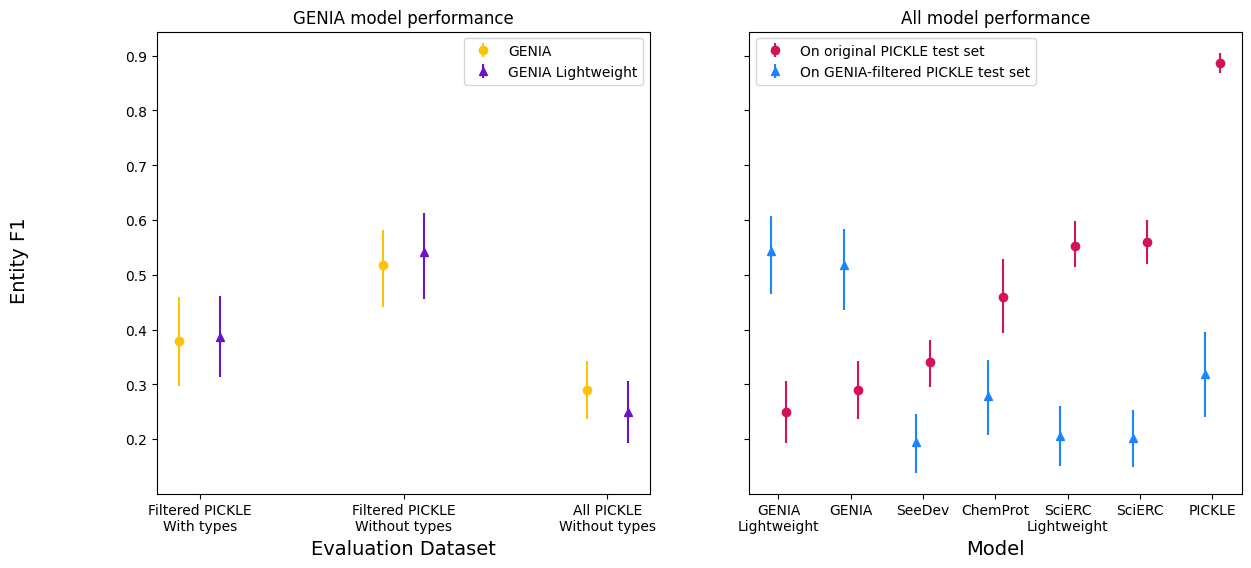

In [82]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

name_x = [orig_label_key[mod] for mod in orig_perf_all["model"]]

axs[0].errorbar(x=perf_plot_data['num_x'] - 0.1, y=perf_plot_data['genia_f1'], yerr=perf_plot_data['genia_ci'], fmt='o', color='#FFC20A', label='GENIA')
axs[0].errorbar(x=perf_plot_data['num_x'] + 0.1, y=perf_plot_data['genialight_f1'], yerr=perf_plot_data['genialight_ci'], fmt='^', color='#6C14C1', label='GENIA Lightweight')

axs[0].set_xticks(perf_plot_data['num_x'], perf_plot_data['semantic_x'], size=10, ha='center')
axs[0].set_xlabel('Evaluation Dataset', size=14)
axs[0].set_title('GENIA model performance')
axs[0].legend()



axs[1].errorbar(x=orig_perf_all["x"] + 0.1, y=orig_perf_all["ent_F1"], yerr=all_no_filter_ent_CIs, fmt="o", color='#D41159', label='On original PICKLE test set')
axs[1].errorbar(x=all_models_on_filtered_without_types["x"] - 0.1, y=all_models_on_filtered_without_types["ent_F1"], yerr=filter_ent_CIs, fmt="^", color='#1A85FF', label='On GENIA-filtered PICKLE test set')

axs[1].set_xticks(orig_perf_all["x"], name_x, size=10, ha='center')
axs[1].set_xlabel('Model', size=14)
axs[1].set_title('All model performance')
axs[1].legend()

fig.supylabel('Entity F1', size=14)

plt.savefig('../data/straying_off_topic_data/model_performance/genia_filtered_performance_F1.png', format='png', bbox_inches='tight', dpi=600)